# Семантическая сегментация изображений поражений кожи


Датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>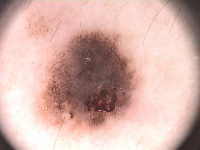</td><td>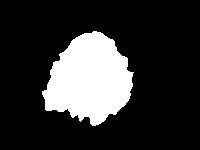</td></tr></table>

Это фотографии двух типов поражений кожи: меланома и родинки.
Попробуем сегментировать их.

In [1]:
! wget https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar

--2020-06-07 19:57:25--  https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4q6kwg8de56eqnc/PH2Dataset.rar [following]
--2020-06-07 19:57:26--  https://www.dropbox.com/s/raw/4q6kwg8de56eqnc/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce5da05595ad91a65bf136f8fbf.dl.dropboxusercontent.com/cd/0/inline/A5MtWBGmEJKY0wFjOt7Fd-sJtUqkyKeIm6TJQMyUkpF2o_q_yOX94QShO-lZaFJDLgVK2yEc3QQjORXRr__aqF6FJNCeHZ3hhu-cRdlYsCTygAUQ2MC-zN660Ykv5i5MnDY/file# [following]
--2020-06-07 19:57:26--  https://uce5da05595ad91a65bf136f8fbf.dl.dropboxusercontent.com/cd/0/inline/A5MtWBGmEJKY0wFjOt7Fd-sJtUqkyKeIm6TJQMyUkpF2o_q_yOX94QShO-lZaFJDLgVK2yEc3QQjORXRr__aqF6FJNCeHZ3hhu-cRdlYsCTy

In [0]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [0]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.

In [0]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений.

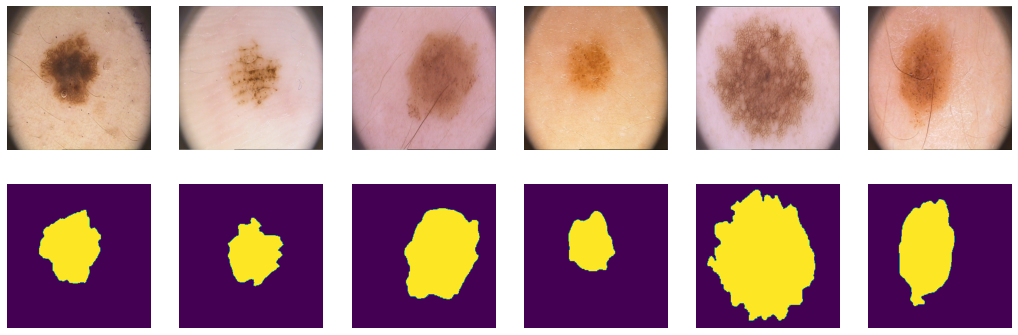

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста.

In [0]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [0]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:

-----------------------------------------------------------------------------------------

# SegNet

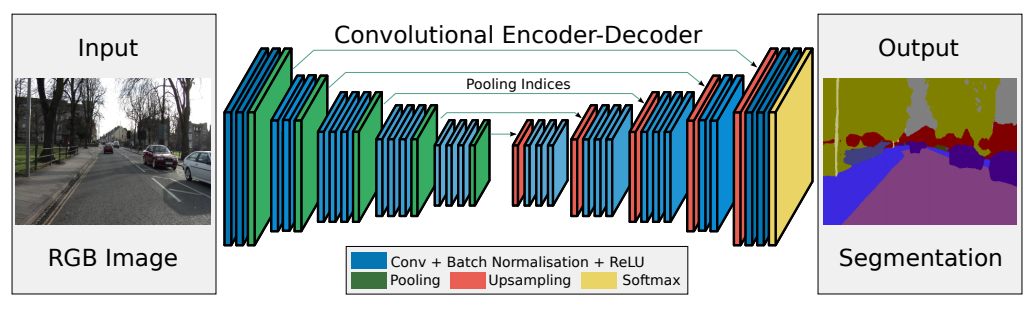

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv01 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bnorm01 = nn.BatchNorm2d(32)
        self.enc_conv02 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm02 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

        self.enc_conv11 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bnorm11 = nn.BatchNorm2d(64)
        self.enc_conv12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm12 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bnorm21 = nn.BatchNorm2d(128)
        self.enc_conv22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm22 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv31 =nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bnorm31 = nn.BatchNorm2d(256)
        self.enc_conv32 =nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bnorm32 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear')  # 16 -> 32
        self.dec_conv01 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_01 = nn.BatchNorm2d(128)
        self.dec_conv02 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_02 = nn.BatchNorm2d(128)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 32 -> 64
        self.dec_conv11 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_11 = nn.BatchNorm2d(64)
        self.dec_conv12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_12 = nn.BatchNorm2d(64)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 64 -> 128
        self.dec_conv21 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_21 = nn.BatchNorm2d(32)
        self.dec_conv22 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_22 = nn.BatchNorm2d(32)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        # encoder
        e1 = F.relu(self.bnorm01(self.enc_conv01(x)))
        e2 = F.relu(self.bnorm02(self.enc_conv02(e1)))
        e3, foo = self.pool0(e2)

        e4 = F.relu(self.bnorm11(self.enc_conv11(e3)))
        e5 = F.relu(self.bnorm12(self.enc_conv12(e4)))
        e6, foo = self.pool1(e5)
        
        e7 = F.relu(self.bnorm21(self.enc_conv21(e6)))
        e8 = F.relu(self.bnorm22(self.enc_conv22(e7)))
        e9, foo = self.pool2(e8)

        e10 = F.relu(self.bnorm31(self.enc_conv31(e9)))
        e11 = F.relu(self.bnorm32(self.enc_conv32(e10)))
        e12, foo = self.pool3(e11)
        
        # bottleneck
        b = F.relu(self.bottleneck_conv(e12))

        # decoder
        d1 = self.upsample0(b)
        d2 = F.relu(self.bnorm_01(self.dec_conv01(d1)))
        d3 = F.relu(self.bnorm_02(self.dec_conv02(d2)))

        d4 = self.upsample1(d3)
        d5 = F.relu(self.bnorm_11(self.dec_conv11(d4)))
        d6 = F.relu(self.bnorm_12(self.dec_conv12(d5)))
        
        d7 = self.upsample2(d6)
        d8 = F.relu(self.bnorm_21(self.dec_conv21(d7)))
        d9 = F.relu(self.bnorm_22(self.dec_conv22(d8)))
        d10 = self.upsample3(d9)
        d11 = F.sigmoid(self.dec_conv3(d10))

        return d11   # no activation

## Метрика

В данном разделе будем использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция лосса

Теперь не менее важным, чем построение архитектуры, является определение оптимизатора и функции потерь.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Используем [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits), эта функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [0]:
def bce_loss(y_real, y_pred):

    return -(y_real*y_pred.clamp(min=0.001).log()+(1-y_real)*(1-y_pred).clamp(min=0.001).log()).mean()

## Тренировка

Мы определим цикл обучения в функции, чтобы можно было повторно использовать его.

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch.to(device)
            Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch.to(device))
            loss =  loss_fn(Y_pred,Y_batch.to(device))# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).cpu().detach().numpy()# detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [0]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        #scores += metric(Y_pred, Y_label.to(device)).mean().item()
        scores += metric(Y_pred > 0.5, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

In [0]:
model = SegNet().to(device)

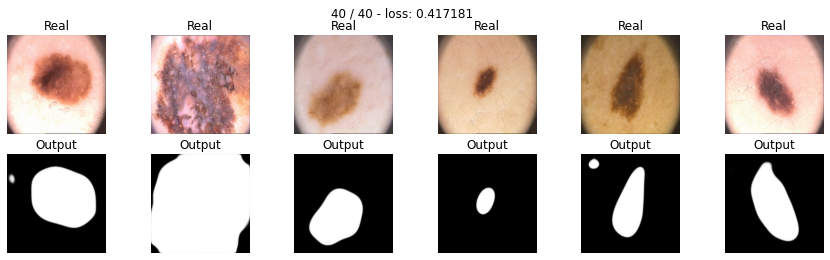

In [0]:
max_epochs = 40
optimization = optim.Adam(model.parameters(), lr=0.001)
train(model, optimization, bce_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.6119999885559082

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса 

 В данном разделе имплементируем три функции потерь:
 DICE, Focal и Tversky loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

In [0]:
def dice_loss(y_real, y_pred):
    smooth = 1.
    iflat = y_pred.contiguous().view(-1)
    tflat = y_real.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

Проводим тестирование:

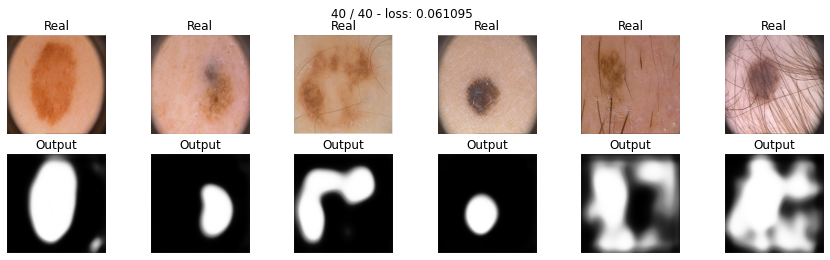

In [21]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters(), lr=0.001)
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model_dice, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.6700000166893005

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы имплементировали BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [1]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    proba = torch.sigmoid(y_pred)
    pt = y_real * proba + (1 - y_real) * (1 - proba)

    loss = (-(1-pt)**gamma * (y_real*y_pred.clamp(min=0.001).log()+(1-y_real)*(1-y_pred).clamp(min=0.001).log())).mean()
    
    return loss

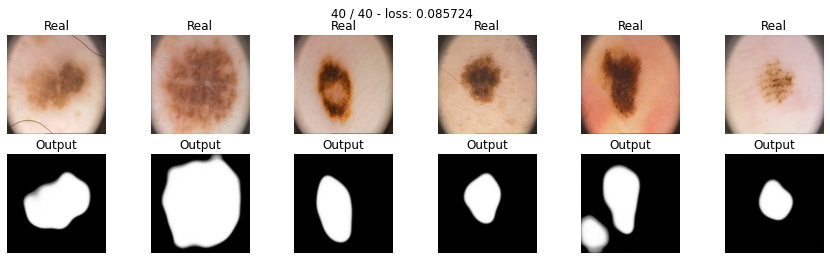

In [0]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters(), lr = 0.001)
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model_focal, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.6620000004768372

**3. Tversky loss:**

In [0]:
def tversky_loss(y_true, y_pred, beta=0.2):
    numerator = torch.sum(torch.sum(y_true * y_pred))
    denominator = torch.sum(torch.sum(y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)))
    loss = 1 - (numerator + 1) / (denominator + 1)
    return loss.mean()

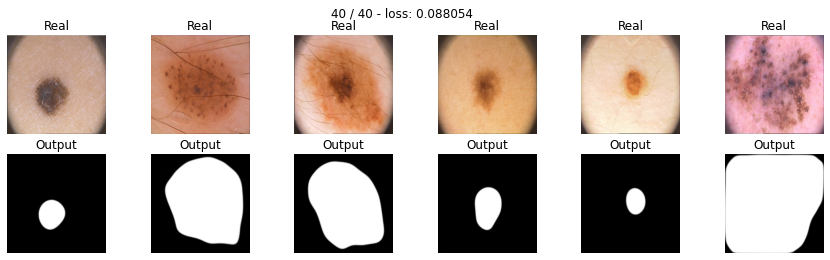

In [0]:
model_tversky = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_tversky.parameters(), lr = 0.001)
train(model_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model_tversky, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.5879999995231628

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

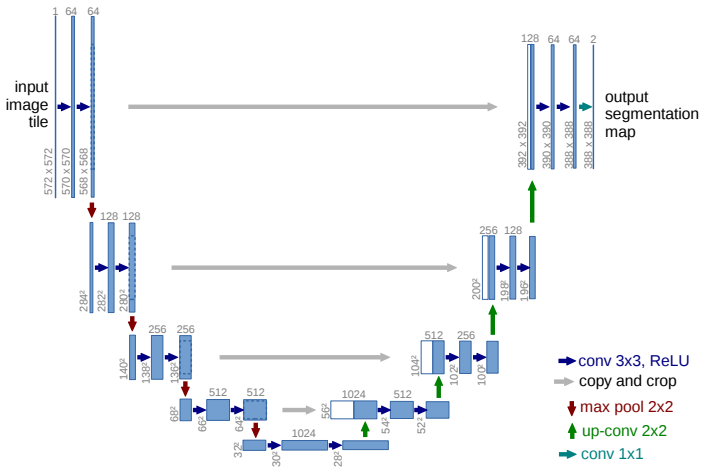

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
 
        # encoder (downsampling)
        self.enc_conv01 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bnorm01 = nn.BatchNorm2d(32)
        self.enc_conv02 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm02 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
 
        self.enc_conv11 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bnorm11 = nn.BatchNorm2d(64)
        self.enc_conv12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm12 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
 
        self.enc_conv21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bnorm21 = nn.BatchNorm2d(128)
        self.enc_conv22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm22 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
 
        self.enc_conv31 =nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bnorm31 = nn.BatchNorm2d(256)
        self.enc_conv32 =nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bnorm32 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16
 
        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)
 
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv01 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.bnorm_01 = nn.BatchNorm2d(256)
        self.dec_conv02 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_02 = nn.BatchNorm2d(128)
 
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv11 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_11 = nn.BatchNorm2d(128)
        self.dec_conv12 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_12 = nn.BatchNorm2d(64)
 
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv21 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_21 = nn.BatchNorm2d(64)
        self.dec_conv22 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_22 = nn.BatchNorm2d(32)
 
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv31 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_3 = nn.BatchNorm2d(32)
        self.dec_conv32 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
 
    def forward(self, x):
        # encoder
        e1 = F.relu(self.bnorm01(self.enc_conv01(x)))
        e2 = F.relu(self.bnorm02(self.enc_conv02(e1)))
        e3, idx0 = self.pool0(e2)
 
        e4 = F.relu(self.bnorm11(self.enc_conv11(e3)))
        e5 = F.relu(self.bnorm12(self.enc_conv12(e4)))
        e6, idx1 = self.pool1(e5)
       
        e7 = F.relu(self.bnorm21(self.enc_conv21(e6)))
        e8 = F.relu(self.bnorm22(self.enc_conv22(e7)))
        e9, idx2 = self.pool2(e8)
 
        e10 = F.relu(self.bnorm31(self.enc_conv31(e9)))
        e11 = F.relu(self.bnorm32(self.enc_conv32(e10)))
        e12, idx3 = self.pool3(e11)
       
        # bottleneck
        b = F.relu(self.bottleneck_conv(e12))
 
        # decoder
        d1 = self.upsample0(b, idx3)
        d2 = torch.cat([d1, e11], dim=1)
        d3 = F.relu(self.bnorm_01(self.dec_conv01(d2)))
        d4 = F.relu(self.bnorm_02(self.dec_conv02(d3)))
 
        d5 = self.upsample1(d4, idx2)
        d6 = torch.cat([d5, e8], dim=1)
        d7 = F.relu(self.bnorm_11(self.dec_conv11(d6)))
        d8 = F.relu(self.bnorm_12(self.dec_conv12(d7)))
       
        d9 = self.upsample2(d8, idx1)
        d10 = torch.cat([d9, e5], dim=1)
        d11 = F.relu(self.bnorm_21(self.dec_conv21(d10)))
        d12 = F.relu(self.bnorm_22(self.dec_conv22(d11)))
 
        d13 = self.upsample3(d12, idx0)
        d14 = torch.cat([d13, e2], dim=1)
        d15 = F.relu(self.bnorm_3(self.dec_conv31(d14)))
        d16 = torch.sigmoid(self.dec_conv32(d15))
 
        return d16

In [0]:
unet_model = UNet().to(device)

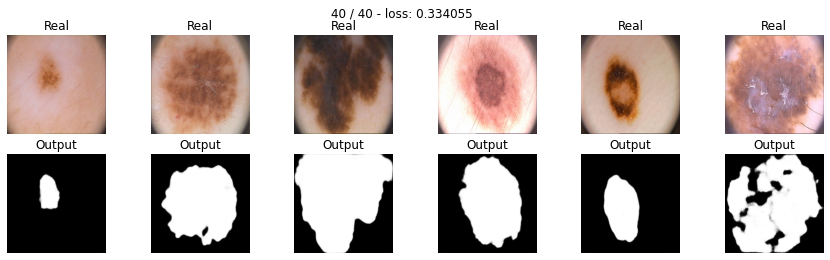

In [0]:
train(unet_model, optim.Adam(unet_model.parameters(), lr = 0.001), bce_loss, 40, data_tr, data_val)

In [0]:
score_model(unet_model, iou_pytorch, data_val)

0.6660000383853912

In [0]:
unet_model = UNet().to(device)

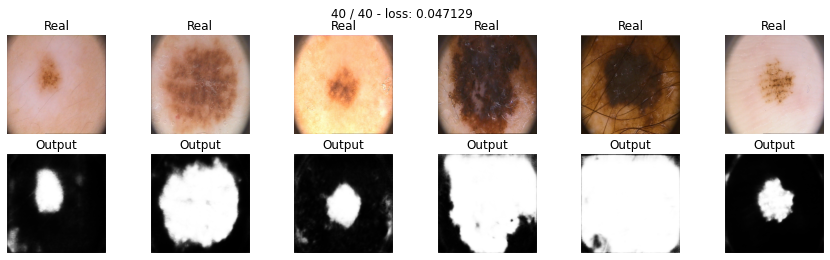

In [0]:
train(unet_model, optim.Adam(unet_model.parameters(), lr = 0.001), dice_loss, 40, data_tr, data_val)

In [0]:
score_model(unet_model, iou_pytorch, data_val)

0.6499999761581421

In [0]:
unet_model = UNet().to(device)

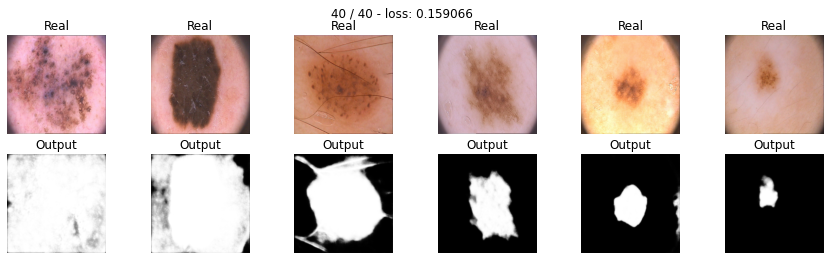

In [0]:
train(unet_model, optim.Adam(unet_model.parameters(), lr = 0.001), focal_loss, 40, data_tr, data_val)

In [0]:
score_model(unet_model, iou_pytorch, data_val)

0.6180000007152557

In [0]:
unet_model = UNet().to(device)

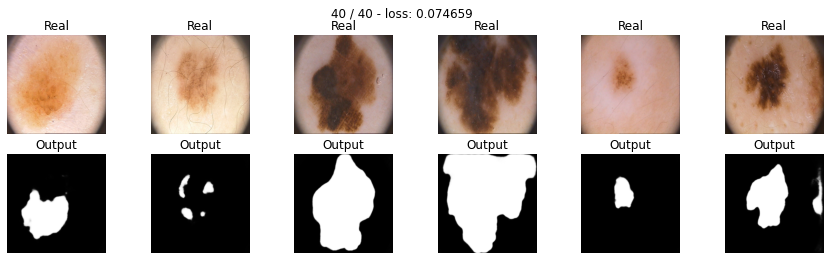

In [0]:
train(unet_model, optim.Adam(unet_model.parameters(), lr = 0.001), tversky_loss, 40, data_tr, data_val)

In [0]:
score_model(unet_model, iou_pytorch, data_val)

0.5740000009536743

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
 
        # encoder (downsampling)
        self.enc_conv01 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bnorm01 = nn.BatchNorm2d(32)
        self.enc_conv02 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm02 = nn.BatchNorm2d(32)
        self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=2)  # 256 -> 128
 
        self.enc_conv11 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bnorm11 = nn.BatchNorm2d(64)
        self.enc_conv12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm12 = nn.BatchNorm2d(64)
        self.pool1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 128 -> 64
 
        self.enc_conv21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bnorm21 = nn.BatchNorm2d(128)
        self.enc_conv22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm22 = nn.BatchNorm2d(128)
        self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 64 -> 32
 
        self.enc_conv31 =nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bnorm31 = nn.BatchNorm2d(256)
        self.enc_conv32 =nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bnorm32 = nn.BatchNorm2d(256)
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 16
 
        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)
 
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv01 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.bnorm_01 = nn.BatchNorm2d(256)
        self.dec_conv02 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_02 = nn.BatchNorm2d(128)
 
        self.upsample1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv11 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_11 = nn.BatchNorm2d(128)
        self.dec_conv12 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_12 = nn.BatchNorm2d(64)
 
        self.upsample2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv21 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_21 = nn.BatchNorm2d(64)
        self.dec_conv22 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_22 = nn.BatchNorm2d(32)
 
        self.upsample3 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv31 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_3 = nn.BatchNorm2d(32)
        self.dec_conv32 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
 
    def forward(self, x):
        # encoder
        e1 = F.relu(self.bnorm01(self.enc_conv01(x)))
        e2 = F.relu(self.bnorm02(self.enc_conv02(e1)))
        e3 = self.pool0(e2)
 
        e4 = F.relu(self.bnorm11(self.enc_conv11(e3)))
        e5 = F.relu(self.bnorm12(self.enc_conv12(e4)))
        e6 = self.pool1(e5)
       
        e7 = F.relu(self.bnorm21(self.enc_conv21(e6)))
        e8 = F.relu(self.bnorm22(self.enc_conv22(e7)))
        e9 = self.pool2(e8)
 
        e10 = F.relu(self.bnorm31(self.enc_conv31(e9)))
        e11 = F.relu(self.bnorm32(self.enc_conv32(e10)))
        e12 = self.pool3(e11)
       
        # bottleneck
        b = F.relu(self.bottleneck_conv(e12))
 
        # decoder
        d1 = self.upsample0(b)
        d2 = torch.cat([d1, e11], dim=1)
        d3 = F.relu(self.bnorm_01(self.dec_conv01(d2)))
        d4 = F.relu(self.bnorm_02(self.dec_conv02(d3)))
 
        d5 = self.upsample1(d4)
        d6 = torch.cat([d5, e8], dim=1)
        d7 = F.relu(self.bnorm_11(self.dec_conv11(d6)))
        d8 = F.relu(self.bnorm_12(self.dec_conv12(d7)))
       
        d9 = self.upsample2(d8)
        d10 = torch.cat([d9, e5], dim=1)
        d11 = F.relu(self.bnorm_21(self.dec_conv21(d10)))
        d12 = F.relu(self.bnorm_22(self.dec_conv22(d11)))
 
        d13 = self.upsample3(d12)
        d14 = torch.cat([d13, e2], dim=1)
        d15 = F.relu(self.bnorm_3(self.dec_conv31(d14)))
        d16 = torch.sigmoid(self.dec_conv32(d15))
 
        return d16

In [0]:
unet2_model = UNet2().to(device)

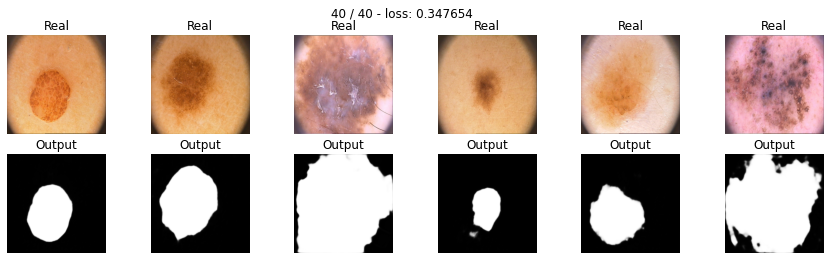

In [0]:
train(unet2_model, optim.Adam(unet2_model.parameters(), lr=0.001), bce_loss, 40, data_tr, data_val)

In [0]:
score_model(unet2_model, iou_pytorch, data_val)

0.6180000007152557

In [0]:
unet2_model = UNet2().to(device)

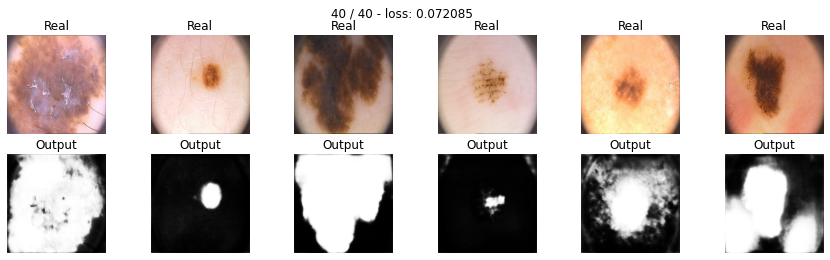

In [0]:
train(unet2_model, optim.Adam(unet2_model.parameters(), lr=0.001), dice_loss, 40, data_tr, data_val)

In [0]:
score_model(unet2_model, iou_pytorch, data_val)

0.5440000146627426

In [0]:
unet2_model = UNet2().to(device)

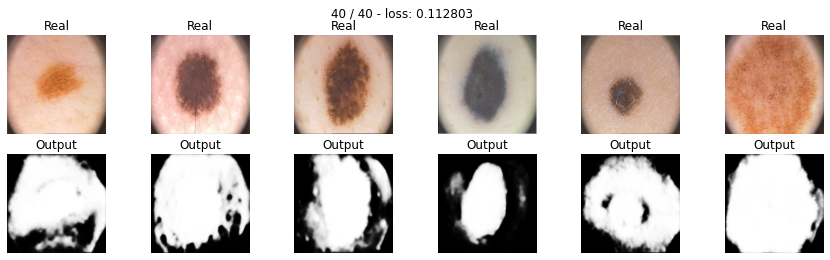

In [41]:
train(unet2_model, optim.Adam(unet2_model.parameters(), lr=0.001), focal_loss, 40, data_tr, data_val)

In [42]:
score_model(unet2_model, iou_pytorch, data_val)

0.21400000154972076

In [0]:
unet2_model = UNet2().to(device)

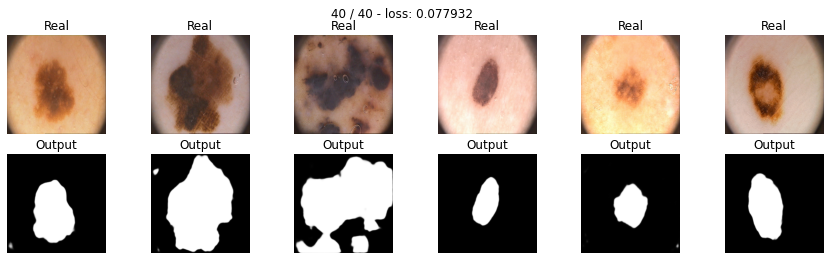

In [0]:
train(unet2_model, optim.Adam(unet2_model.parameters(), lr=0.001), tversky_loss, 40, data_tr, data_val)

In [0]:
score_model(unet2_model, iou_pytorch, data_val)

0.620000034570694

# Отчет

DISCLAIMER: 

Результат анализа мог бы быть другим, если бы для каждой архитектуры и лосса была цель выжать максимально возможное качество. 
В этом случае можно было бы повысить скор за счет подбора оптимального кол-ва эпох, оптимайзера и политики изменения лернинг рейта (шедулеров). 

Однако в данной работе я скорее преследовал цель сравнить архитектуры и лоссы при равных условиях по кол-ву эпох, оптимайзеру и лернинг рейту, 
поэтому во всей работе эти гиперпараметры я зафиксировал

Как видно из результатов обучения, самые удачные комбинации архитектуры и лосса - это SegNet с BCE Loss и U-Net с DICE Loss